# MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import classification_report

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision.models import resnet18

## Load data

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

DATA_DIR = '/run/media/andreas/files/datasets/'

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
torch.manual_seed(10)
# generator = torch.Generator()
# generator.manual_seed(10)
trainset = MNIST(DATA_DIR, download=True, train=True, transform=transform)
valset = MNIST(DATA_DIR, download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
valloader = DataLoader(valset, batch_size=64, shuffle=True, num_workers=8)

## ResNet18 Model

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data

class ResNetMNIST(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = resnet18(num_classes=10)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = nn.CrossEntropyLoss()

  @auto_move_data
  def forward(self, x):
    return self.model(x)

  def forward_xai(self, x):
    x = self.model.conv1(x)
    x = self.model.bn1(x)
    x = self.model.relu(x)
    x = self.model.maxpool(x)

    x = self.model.layer1(x)
    x = self.model.layer2(x)
    x = self.model.layer3(x)
    x = self.model.layer4(x)
    return x
  
  def training_step(self, batch, batch_no):
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.005)


def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

In [4]:
# Train model
# model = ResNetMNIST()
# trainer = pl.Trainer(
#     max_epochs=1,
#     progress_bar_refresh_rate=20
# )
#
# trainer.fit(model, trainloader)

# Save model
# trainer.save_checkpoint("resnet18_mnist.pt")

# Load model
inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt")

### Classification Report: ResNet18 on MNIST

In [5]:
true_y, pred_y = [], []
for batch in valloader:
  x, y = batch
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.988     0.992     0.990       980
           1      0.989     0.996     0.993      1135
           2      0.986     0.987     0.987      1032
           3      0.909     1.000     0.952      1010
           4      0.997     0.969     0.983       982
           5      0.996     0.920     0.957       892
           6      0.993     0.990     0.991       958
           7      0.982     0.982     0.982      1028
           8      0.986     0.979     0.982       974
           9      0.972     0.961     0.967      1009

    accuracy                          0.979     10000
   macro avg      0.980     0.978     0.978     10000
weighted avg      0.980     0.979     0.979     10000



## Convert training and validation data to latent space

We transform data to a binary classification problem. Predict if image is an 8 (`+1`) or not (`-1`).

In [6]:

def get_latent(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  out = model.forward_xai(x)
  return out

def convert_to_latent(loader, max_length=80000):
  xo, xl, yl = [], [], []
  for batch in loader:
    x, y = batch
    res = get_latent(x, inference_model)
    res = res.reshape((res.shape[0], res.shape[1] * res.shape[2] * res.shape[3]))
    xo.extend(x.numpy())
    xl.extend(res.numpy())
    
    yt = y.numpy()
    yt[yt != 8] = -1
    yt[yt == 8] = +1
    yl.extend(yt)
    if len(yl) >= max_length:
      break
  print(f"Converted {len(xo)} datapoints to latent space.")
  return np.array(xo), np.array(xl), np.array(yl)

train_latent = convert_to_latent(trainloader)
val_latent = convert_to_latent(valloader)

Converted 60000 datapoints to latent space.
Converted 10000 datapoints to latent space.


## Train SVC on latent space

Classification report of resnet18 (last linear layer) -> SVC

In [7]:
ksvm = SVC(kernel='rbf')
ksvm.fit(train_latent[1], train_latent[2])

true_y, pred_y = val_latent[2], ksvm.predict(val_latent[1])
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.998     0.999     0.998      9026
           1      0.988     0.983     0.985       974

    accuracy                          0.997     10000
   macro avg      0.993     0.991     0.992     10000
weighted avg      0.997     0.997     0.997     10000



## Analysis
Select an 8 from the validation set.

[1]


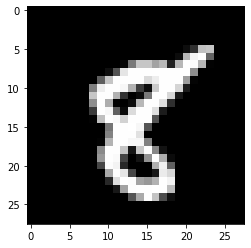

In [8]:
orig_i = np.argmax(val_latent[2])
print(ksvm.predict(val_latent[1][orig_i:orig_i+1, :]))
plt.imshow(val_latent[0][orig_i][0], cmap='gray')

### Calculate Kernel-Matrix of selected image and support vectors

Calculate the amount of label flips required for misclassification.

In [9]:
km = rbf_kernel(ksvm.support_vectors_, val_latent[1][orig_i:orig_i+1, :])
km *= train_latent[2][ksvm.support_].reshape(len(ksvm.support_), 1)

def ksvm_label_flip(inds):
  prev = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
  # Create coefficient backup
  backup = np.copy(ksvm._dual_coef_)
  # Flip labels
  ksvm._dual_coef_[0, inds] = -ksvm._dual_coef_[0, inds]
  # Check prediction
  after = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
  # Restore coefficients
  ksvm._dual_coef_ = backup
  return prev, after

# Find the tipping point
label_flip_len = -1
inds = np.flip(km.argsort(axis=0).flatten())
beyond_end = 5
for i in range(1, len(inds)+1):
  p, a = ksvm_label_flip(inds[:i])
  if p != a:
    print("Label flips:", label_flip_len := i)
    inds = inds[:label_flip_len + beyond_end]
    break

Label flips: 3


Plot images that need to be flipped (+1)

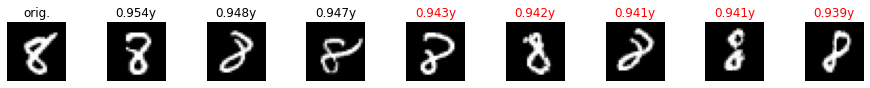

In [10]:
plt.figure(figsize=(14, 10))
plt.subplot(10,10,1); plt.title('orig.'); plt.axis('off')
plt.imshow(val_latent[0][orig_i][0], cmap='gray')
for i, ind in enumerate(inds):
  ti = ksvm.support_[ind]
  plt.subplot(10,10,i+2)
  plt.axis('off')
  plt.title(
    "{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ti] == 1 else 'n'), 
    fontdict={ 'color': 'red' if i >= label_flip_len else 'black' })
  plt.imshow(train_latent[0][ti][0], cmap='gray')
plt.tight_layout()
plt.show()

### Calculate Linear Reconstruction
Use flipped images as base vector $x_i$ with parameters $z_i$ to reconstruct original image $x'$

$$
\sum_i z_i x_i = x',
$$
using MSE loss.


Optimization terminated successfully.
         Current function value: 15.380543
         Iterations: 95
         Function evaluations: 209


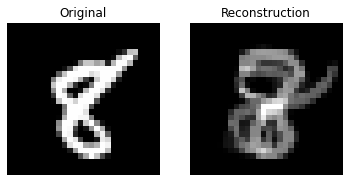

Reconstruction parameter:  [0.47668473 0.07746725 0.35164911]


In [11]:
from scipy.optimize import minimize

z0 = np.random.rand(label_flip_len)

def reconstrution(z):
  zp = 0
  for i in range(label_flip_len):
    ti = ksvm.support_[inds[i]]
    zp += train_latent[0][ti] * z[i]
  return zp

def plot_reconstruction(z):
  r = reconstrution(z)
  plt.subplot(1, 2, 1)
  plt.axis('off')
  plt.title("Original")
  plt.imshow(val_latent[0][orig_i].reshape(28,28), cmap='gray')
  plt.subplot(1, 2, 2)
  plt.axis('off')
  plt.title("Reconstruction")
  plt.imshow(r.reshape(28,28), cmap='gray')
  plt.show()


def reconstrution_loss(z):
  original_image = val_latent[0][orig_i]
  r = reconstrution(z)
  return np.linalg.norm(r - original_image)

res = minimize(reconstrution_loss, z0,
               method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

plot_reconstruction(res.x)
print('Reconstruction parameter: ', res.x)

## Compare feature space directly

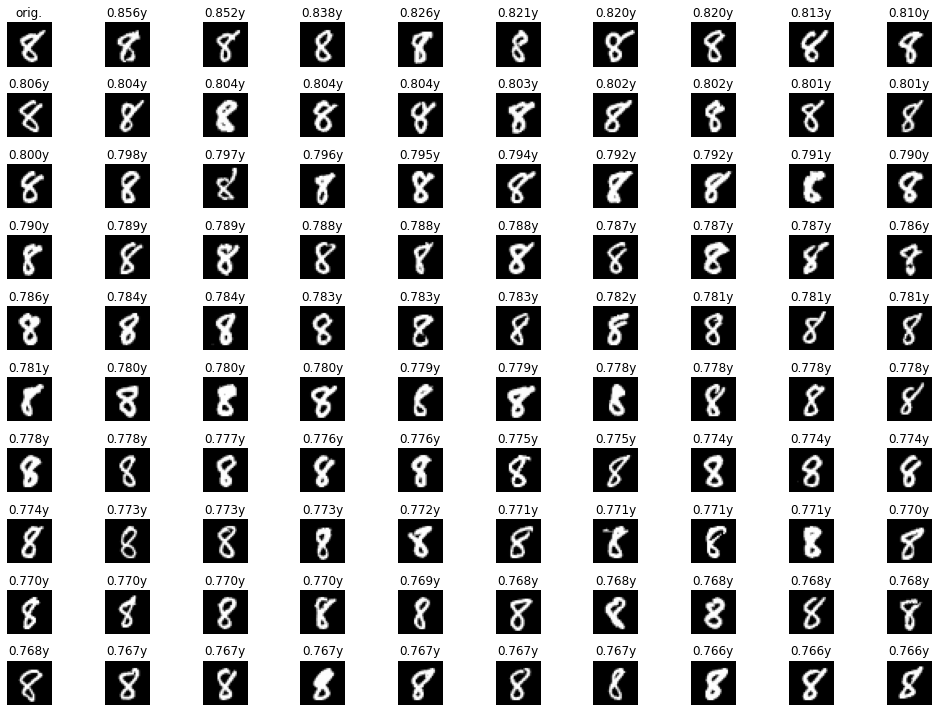

In [12]:
km = rbf_kernel(train_latent[0].reshape(train_latent[0].shape[0], 28*28), val_latent[0][orig_i:orig_i+1, :].reshape(1, 28*28))
km *= train_latent[2].reshape(len(train_latent[2]), 1)

inds = np.flip(km.argsort(axis=0).flatten())[:99]
# inds = km.argsort(axis=0).flatten()[:99]

plt.figure(figsize=(14, 10))
plt.subplot(10,10,1); plt.title('orig.'); plt.axis('off')
plt.imshow(val_latent[0][orig_i][0], cmap='gray')
for i, ind in enumerate(inds):
  # ti = ksvm.support_[ind]
  ti = ind
  plt.subplot(10,10,i+2)
  plt.axis('off')
  plt.title("{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ti] == 1 else 'n'))
  plt.imshow(train_latent[0][ti][0], cmap='gray')
plt.tight_layout()
plt.show()